Look into initial results with CLASP+CLUBB_MF

In [2]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')


## A few useful functions

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [4]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [5]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [6]:
def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [7]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    # DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )
    
    # DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DS.P0.values/100        # mb 
#     hyam   = np.squeeze(DS.hyam.values)[:]
#     hybm   = np.squeeze(DS.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','WindMagnitude','CONCLD','QT','GCLDLWP',
#                           'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_upbuoy','edmf_updet','edmf_upent',
#                           ## Add budget terms 
                          # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                           'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                           'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                          ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

    # - - - - - - - - - - - - - - - - - - - - - - - -
      
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
                
    return DS

In [8]:
def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]




    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [9]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [10]:
def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                           ])
    
    for iVar in range(len(varSels)): 

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [11]:
def preprocess_h0(ds):
    
#     keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
#                 ## Add budget terms 
#                 # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                 'wpthlp','wprtp',
#                 # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
#                 ]
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
#                 'WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP2THLP_CLUBB','WPTHLP2_CLUBB','WPRTPTHLP_ZM_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                # 'PRECZ',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [12]:
def preprocess_h1(ds):
    
    keepVars = [
#                 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
#                 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [13]:
def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
#     dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [14]:
def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [15]:
## Pre-processing to get CLM data

def preprocessCLM_h0(ds):
    
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    
    return dsSel



In [16]:
## Pre-processing to get CLM data

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
    dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean()
    
    return dsSel


For plotting

In [17]:
def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [18]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_h2.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_h2.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI_h2.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI_h2.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [19]:
def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax

## Read in data

**Single column CAM and CLM data**

In [20]:
# archiveDir  = '/scratch/cluster/mdfowler/tempOutput_claspMF/'
testDir     = [
#                '/scratch/cluster/mdfowler/clmInit_addTQvarnc/',
#                '/scratch/cluster/mdfowler/clmInit_addTQvarnc/',
               '/scratch/cluster/mdfowler/clmInit_TQvarnc_Lopt6/', 
               '/scratch/cluster/mdfowler/clmInit_TQvarnc_Lopt6/',
              ]

case_names  = [
               'clubbMF',
               'clasp+MF',
#                'clubbMF_Lopt6',
#                'clasp+MF_Lopt6',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
#                 'usePatchDataFALSE_setSfcFlxFALSE_mfMergeMar_clmInit',
#                 'usePatchDataTRUE_setSfcFlxFALSE_mfMergeMar_clmInit',
                'usePatchDataFALSE_setSfcFlxFALSE_clmInit_edmfTQvarnc_LOPT6',
                'usePatchDataTRUE_setSfcFlxFALSE_clmInit_edmfTQvarnc_LOPT6',
              ]

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir[iCase]+caseStart+caseStrings[iCase]+'*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(testDir[iCase]+caseStart+caseStrings[iCase]+'*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(testDir[iCase]+caseStart+caseStrings[iCase]+'*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(testDir[iCase]+caseStart+caseStrings[iCase]+'*cam.h3*'))

    listFilesCLM_h1 = np.sort(glob.glob(testDir[iCase]+caseStart+caseStrings[iCase]+'*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir[iCase]+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
     # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH2   = xr.merge([case_h2, case_h2_2d])
    caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3  = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3 = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    procDS_h3 = process_camData_h3( caseH3, procDS  )

            
    ## Combine all the cases into 
    case_allDays      = procDS.assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.assign_coords({"case":  case_names[iCase]})
    h3_allDays        = procDS_h3.assign_coords({"case":  case_names[iCase]})
                        
    if iCase==0:
        scamDS    = case_allDays
        scamDS_h2 = h2_allDays
        scamDS_h3 = h3_allDays
    else: 
        scamDS    = xr.concat([scamDS, case_allDays], "case") 
        scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
        scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 

           
    ## Read in CLM datasets too 
 
    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')

    caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
        clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
    else: 
        clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
    print('Done with CLM h0 files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
    

*** Starting on case clubbMF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h3 files loaded with mfdataset


ValueError: conflicting sizes for dimension 'nens': length 10 on 'nens' and length 25 on 'edmf_upa'

In [15]:
# ## Assign a more helpful itme coordinate to clm datasets 
# clmDS_h0['time'] = scamDS['time']
# clmDS_h1['time'] = scamDS['time']

**Figure out how to use the subcycle output well**

In [42]:
# # Parallel loop over time 
# def computeSumMacmic_parallel(recArray1, recArray2):
        
#     total_var = np.full([len(recArray1.levInterp.values)], np.nan)
    
#     for iLev in range(len(recArray1.levInterp.values)):
#         part1 = recArray1.isel(levInterp=iLev) 
#         part2 = recArray2.isel(levInterp=iLev)
        
#         if ((np.isfinite(part1.values)==False) & (np.isfinite(part2.values)==False)):
#             total_var[iLev] = np.nan
#         else:
#             total_var[iLev] = np.nansum([part1.values, part2.values])
    
#     return total_var

**Note:** The way this is working out below, it's fine to take the mean over the new, stacked axis because there's only one cycle in macmic1 and macmic2 with my output frequency. But that's not foolproof!! 

In [20]:
var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
           'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
           'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

for iVar in range(len(var1)):
    print('Computing %s' % (varSave[iVar]))
    
    varCyc1 = scamDS_h3[var1[iVar]].isel(lat=0, lon=0)
    varCyc2 = scamDS_h3[var2[iVar]].isel(lat=0, lon=0)
    
    ## This seems to work... 
    s = np.stack((varCyc1, varCyc2))
#     C = np.nansum(s, axis=0)
    C = np.nanmean(s, axis=0)
    C[np.all(np.isnan(s), axis=0)] = np.nan
    
    scamDS_h2[varSave[iVar]]  = (('case','time','nens','levInterp'), np.squeeze(C))


Computing up_macmicAvg_interp
Computing dn_macmicAvg_interp
Computing upa_macmicAvg_interp
Computing dna_macmicAvg_interp
Computing thlu_macmicAvg_interp
Computing qtu_macmicAvg_interp
Computing thld_macmicAvg_interp
Computing qtd_macmicAvg_interp


In [21]:
## Get number of plumes at each time/level
nPlumesActive = scamDS_h2.thlu_macmicAvg_interp.count(dim='nens')
print(np.shape(nPlumesActive))

scamDS['nPlumesActive'] = (('case','time','levInterp'), nPlumesActive)


(2, 13320, 78)


In [91]:
# print('iT   nPlumesActive   otherCalc')
# for iT in range(100):
#     iLev = -1
    
#     selDS = scamDS_h2.isel(levInterp=iLev, time=iT, lat=0, lon=0, case=0)
#     nP = len(np.where(np.isfinite(selDS.thlu_macmicAvg_interp.values)==True)[0])
    
#     print('%2i %10i %10i' % (iT, nP, nPlumesActive.isel(case=0, levInterp=-1,time=iT).values))
    
    

iT   nPlumesActive   otherCalc
 0          0          0
 1          0          0
 2          0          0
 3          0          0
 4          0          0
 5          0          0
 6          0          0
 7          0          0
 8          0          0
 9          0          0
10          0          0
11          0          0
12          0          0
13          0          0
14          0          0
15          2          2
16          3          3
17          4          4
18          4          4
19          8          8
20          7          7
21         10         10
22         10         10
23         10         10
24         10         10
25         10         10
26         10         10
27         10         10
28         10         10
29         10         10
30         10         10
31         10         10
32         10         10
33         10         10
34         10         10
35         10         10
36         10         10
37         10         10
38         10      

In [41]:
# ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# ## Make sure the additions are working properly 
# ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# nTimes = len(scamDS_h3.time.values)
# nEns   = len(scamDS_h3.nens.values)

# # iCase_clubb = np.where(scamDS_h3.case.values=='clubbMF')[0]
# iCase_clasp = np.where(scamDS_h3.case.values=='clasp+MF')[0]

# var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
#            'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

# var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
#            'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

# varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
#            'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

# # for iVar in range(1):
# for iVar in range(len(var1)):
#     print('Computing %s' % (varSave[iVar]))
    
#     totVar = np.full([len(scamDS_h3.case.values), nTimes, nEns,
#                       len(scamDS_h3.levInterp.values), 
#                       len(scamDS_h3.lat.values), len(scamDS_h3.lon.values)], np.nan)
    
#     for iEns in range(nEns):
# #         varCycle1_clubb = scamDS_h3[var1[iVar]].isel(case=iCase_clubb, nens=iEns, lat=0, lon=0)
# #         varCycle2_clubb = scamDS_h3[var2[iVar]].isel(case=iCase_clubb, nens=iEns, lat=0, lon=0)
        
#         varCycle1_clasp = scamDS_h3[var1[iVar]].isel(case=iCase_clasp, nens=iEns, lat=0, lon=0)
#         varCycle2_clasp = scamDS_h3[var2[iVar]].isel(case=iCase_clasp, nens=iEns, lat=0, lon=0)
        
# #         totVar[iCase_clubb,:,iEns,:,0,0] = Parallel(n_jobs=4)(delayed(computeSumMacmic_parallel)(varCycle1_clubb.isel(time=i),
# #                                                                                                  varCycle2_clubb.isel(time=i),) for i in range(nTimes))

#         totVar[iCase_clasp,:,iEns,:,0,0] = Parallel(n_jobs=4)(delayed(computeSumMacmic_parallel)(varCycle1_clasp.isel(time=i),
#                                                                                                  varCycle2_clasp.isel(time=i)) for i in range(nTimes))
            
#         print('Done with ensemble %i' % (iEns) )

#     scamDS_h2[varSave[iVar]]  = (('case','time','nens','levInterp','lat','lon'), totVar)
#     print('Saved variable %s' %(varSave[iVar]))
    
    

Sanity check that the nansum used above is computing the right sum of things

In [47]:
## Get useful mean per cycle of the edmf plume data (merge macmic1 and macmic2)
nTime = len(scamDS_h3.time.values)
nCyc  = len(scamDS_h3.ncyc.values)
nCase = len(scamDS_h3.case.values)
nEns  = len(scamDS_h3.nens.values)
nLev  = len(scamDS_h3.levInterp.values)

# print('Number of times: %i\nNumber of subcycles: %i\nNumber of cases: %i' % (nTime, nCyc, nCase))

var1 = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
        'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']
var2 = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
        'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']
varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
           'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']


for iCase in range(2):
    print('---CASE:%s----' % (scamDS_h3.case.values[iCase]))
    for iVar in range(len(var1)):
#     for iVar in range(2):
        print('  variable: %s' % (varSave[iVar]))

        totVar = np.full([nCase, nTime, nEns, nLev], np.nan)
#         totVar = np.full([nTime, nEns, nLev], np.nan)
        
#         for iT in range(1):
        iT = 50
        selDS_pt1 = scamDS_h3[var1[iVar]].isel(time=iT, case=iCase, lon=0, lat=0)
        selDS_pt2 = scamDS_h3[var2[iVar]].isel(time=iT, case=iCase, lon=0, lat=0)

        print('    EnsNum      macmic1      macmic2      mean      nanmeanSaveC')
        for iLev in range(len(selDS_pt1.levInterp.values)): 
            for iEns in range(nEns):
                if ((np.isfinite(selDS_pt1.isel(nens=iEns,levInterp=iLev))==False) & (np.isfinite(selDS_pt2.isel(nens=iEns,levInterp=iLev))==False)):
                        totVar[iCase,iT,iEns,iLev] = np.nan
#                         totVar[iT,iEns,iLev] = np.nan
                else:
                    totVar[iCase,iT,iEns,iLev] = np.nanmean([selDS_pt1.isel(nens=iEns,levInterp=iLev), 
#                     totVar[iCase,iT,iEns,iLev] = np.nansum([selDS_pt1.isel(nens=iEns,levInterp=iLev), 
#                     totVar[iT,iEns,iLev] = np.nansum([selDS_pt1.isel(nens=iEns,levInterp=iLev), 
                                                            selDS_pt2.isel(nens=iEns,levInterp=iLev)])

                
                
                if iLev==(len(selDS_pt1.levInterp.values)-3):
                    print('%6i %15.3f %12.3f %10.3f %12.3f' % (iEns, selDS_pt1.isel(nens=iEns,levInterp=iLev),
                                                              selDS_pt2.isel(nens=iEns,levInterp=iLev), 
                                                              np.mean([selDS_pt1.isel(nens=iEns,levInterp=iLev), selDS_pt2.isel(nens=iEns,levInterp=iLev)]) , 
#                                                               totVar[iCase,iT,iEns,iLev],
#                                                               totVar[iT,iEns,iLev], 
                                                             scamDS_h2[varSave[iVar]].values[iCase,iT,iEns,iLev] ))
                    
            

---CASE:clubbMF----
  variable: up_macmicAvg_interp
    EnsNum      macmic1      macmic2      mean      nanmeanSaveC
     0           1.521        2.035      1.778        1.778
     1           1.238        1.045      1.142        1.142
     2           0.965        1.344      1.155        1.155
     3           1.202        1.519      1.360        1.360
     4           2.767        1.097      1.932        1.932
     5           1.157        2.362      1.759        1.759
     6           1.612        1.380      1.496        1.496
     7           0.974        2.877      1.926        1.926
     8           1.241        2.734      1.988        1.988
     9           0.689        1.643      1.166        1.166
  variable: dn_macmicAvg_interp
    EnsNum      macmic1      macmic2      mean      nanmeanSaveC
     0           0.000        0.000      0.000        0.000
     1           0.000        0.000      0.000        0.000
     2           0.000        0.000      0.000        0.000
     3

     0         305.145      305.224    305.184      305.184
     1         305.204      304.857    305.030      305.030
     2         305.079      305.090    305.085      305.085
     3         304.883      304.819    304.851      304.851
     4         305.569      304.717    305.143      305.143
     5         304.783      304.739    304.761      304.761
     6         304.763      304.796    304.779      304.779
     7         304.778      304.915    304.846      304.846
     8         304.796      305.109    304.953      304.953
     9         304.775      304.954    304.864      304.864
  variable: qtu_macmicAvg_interp
    EnsNum      macmic1      macmic2      mean      nanmeanSaveC
     0           0.014        0.014      0.014        0.014
     1           0.014        0.014      0.014        0.014
     2           0.014        0.014      0.014        0.014
     3           0.014        0.014      0.014        0.014
     4           0.015        0.014      0.014        0.014
  

In [25]:
np.nanmean(scamDS_h2.dn_macmicAvg_interp.values)

0.0

### Get the contribution of MF that can be added to CLUBB's moments

In [43]:
# # Parallel loop over time 
# def computeSum_parallel(recArrayCLUBB, recArrayMF, clubbMult, i):
    
# #     if np.remainder(i,10)==0:
# #         print('Now on time...', i) 
        
#     total_var = np.full([len(recArrayCLUBB.levInterp.values)], np.nan)
    
#     for iLev in range(len(recArrayCLUBB.levInterp.values)):
#         clubbPart = recArrayCLUBB.isel(levInterp=iLev) * clubbMult
#         mfPart    = recArrayMF.isel(levInterp=iLev)
        
#         total_var[iLev] = np.nansum([clubbPart.values, mfPart.values])
    
#     return total_var

In [44]:
# testDS = scamDS_h2.edmf_upw_interp.isel(levInterp=-5, lat=0, lon=0, case=1)

# for iT in range(len(testDS.time.values)):
#     sumPlumes = np.sum(np.isfinite(testDS.isel(time=iT).values))
#     if (sumPlumes>0) & (sumPlumes<10):
#         print('iT: ',iT, '    NumPlumes: ',sumPlumes)
    


In [ ]:
varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
           'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']


In [48]:
np.shape(scamDS_h2['thlu_macmicAvg_interp'].values)

(2, 13320, 10, 78)

In [30]:
scamDS_h2

<xarray.Dataset>
Dimensions:                (case: 2, ilev: 59, lat: 1, lev: 58, levInterp: 78, lon: 1, nens: 10, time: 13320)
Coordinates:
  * lat                    (lat) float64 36.6
  * lon                    (lon) float64 262.5
  * lev                    (lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * ilev                   (ilev) float64 2.055 3.98 6.909 ... 987.4 995.1 1e+03
  * time                   (time) datetime64[ns] 2015-06-06T07:03:30 ... 2018...
  * nens                   (nens) int64 0 1 2 3 4 5 6 7 8 9
  * levInterp              (levInterp) float64 200.0 210.0 220.0 ... 960.0 970.0
  * case                   (case) object 'clubbMF' 'clasp+MF'
Data variables:
    edmf_upa               (case, time, nens, ilev, lat, lon) float32 nan ......
    edmf_upw               (case, time, nens, ilev, lat, lon) float32 nan ......
    edmf_upqt              (case, time, nens, ilev, lat, lon) float32 nan ......
    edmf_upthl             (case, time, nens, ilev, lat, lon) float32 nan ......
    edmf_cloudfrac         (case, time, lev, lat, lon, nens, ilev) float32 na...
    edmf_dnw               (case, time, nens, ilev, lat, lon) float32 nan ......
    edmf_precc             (case, time, ilev, lat, lon, nens) float32 nan ......
    edmf_upa_interp        (case, time, nens, levInterp, lat, lon) float64 na...
    edmf_upw_interp        (case, time, nens, levInterp, lat, lon) float64 na...
    edmf_upqt_interp       (case, time, nens, levInterp, lat, lon) float64 na...
    edmf_upthl_interp      (case, time, nens, levInterp, lat, lon) float64 na...
    edmf_dnw_interp        (case, time, nens, levInterp, lat, lon) float64 na...
    up_macmicAvg_interp    (case, time, nens, levInterp) float64 nan nan ... nan
    dn_macmicAvg_interp    (case, time, nens, levInterp) float64 nan nan ... nan
    upa_macmicAvg_interp   (case, time, nens, levInterp) float64 nan nan ... nan
    dna_macmicAvg_interp   (case, time, nens, levInterp) float64 nan nan ... nan
    thlu_macmicAvg_interp  (case, time, nens, levInterp) float64 nan nan ... nan
    qtu_macmicAvg_interp   (case, time, nens, levInterp) float64 nan nan ... nan
    thld_macmicAvg_interp  (case, time, nens, levInterp) float64 nan nan ... nan
    qtd_macmicAvg_interp   (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_wp2               (case, time, levInterp) float64 nan nan ... nan nan
    total_wp2              (case, time, levInterp) float64 0.0004 ... 0.1487
    edmf_wpthlp            (case, time, levInterp) float64 nan nan ... nan nan
    total_wpthlp           (case, time, levInterp) float64 -2.152e-05 ... -0....
    edmf_wprtp             (case, time, levInterp) float64 nan nan ... nan nan
    total_wprtp            (case, time, levInterp) float64 1.764e-10 ... 9.58...
    edmf_thlp2             (case, time, levInterp) float64 nan nan ... nan nan
    total_thlp2            (case, time, levInterp) float64 0.0001432 ... 0.00...
    edmf_rtp2              (case, time, levInterp) float64 nan nan ... nan nan
    total_rtp2             (case, time, levInterp) float64 2.595e-15 ... 3.55...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_se...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_5

**Based on clubb_mf and clubb_intr:**
- Environmental thl is thlm in clubb_intr 
- Environmental qt is rtm in clubb_intr

In [34]:
# edmf_wp2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                      len(scamDS_h2.levInterp.values)])

# edmf_wpthlp = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                         len(scamDS_h2.levInterp.values)])

# edmf_wprtp = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                        len(scamDS_h2.levInterp.values)])

# edmf_thlp2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                        len(scamDS_h2.levInterp.values)])

# edmf_rtp2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                       len(scamDS_h2.levInterp.values)])

# edmf_aw = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                       len(scamDS_h2.levInterp.values)])

# edmf_wpthlp_v2 = np.zeros([len(scamDS_h2.case.values), len(scamDS_h2.time.values),
#                         len(scamDS_h2.levInterp.values)])

# # edmf_meanUPW   = scamDS_h2.edmf_upw_interp.mean(dim='nens')    # m/s
# # edmf_meanUPTHL = scamDS_h2.edmf_upthl_interp.mean(dim='nens')  # K
# # edmf_meanUPRT  = scamDS_h2.edmf_upqt_interp.mean(dim='nens')   #kg/kg


# for iEns in range(len(scamDS_h2.nens.values)):
#     selEns   = scamDS_h2.isel(nens = iEns, lat=0,lon=0)
    
#     edmf_wp2 = ( edmf_wp2 + (selEns.upa_macmicAvg_interp.values * 
#                 ((selEns.up_macmicAvg_interp.values)**2)) + 
#                 (selEns.dna_macmicAvg_interp.values * 
#                 ((selEns.dn_macmicAvg_interp.values)**2)) )

    
#     edmf_wpthlp = ( edmf_wpthlp + (selEns.upa_macmicAvg_interp.values * 
#             ((selEns.up_macmicAvg_interp.values)*(selEns.thlu_macmicAvg_interp.values - scamDS.thlm_interp.isel(lat=0,lon=0).values)) ) + 
#             (selEns.dna_macmicAvg_interp.values * 
#             ((selEns.dn_macmicAvg_interp.values)*(selEns.thld_macmicAvg_interp.values - scamDS.thlm_interp.isel(lat=0,lon=0).values)) ) )

#     edmf_wprtp = ( edmf_wprtp + (selEns.upa_macmicAvg_interp.values * 
#             ((selEns.up_macmicAvg_interp.values)*(selEns.qtu_macmicAvg_interp.values - scamDS.rtm_interp.isel(lat=0,lon=0).values)) ) + 
#             (selEns.dna_macmicAvg_interp.values * 
#             ((selEns.dn_macmicAvg_interp.values)*(selEns.qtd_macmicAvg_interp.values - scamDS.rtm_interp.isel(lat=0,lon=0).values)) ) )

    
#     edmf_thlp2 = ( edmf_thlp2 + (selEns.upa_macmicAvg_interp.values * 
#                 ((selEns.thlu_macmicAvg_interp.values - scamDS.thlm_interp.isel(lat=0,lon=0).values)**2)) + 
#                 (selEns.dna_macmicAvg_interp.values * 
#                 ((selEns.thld_macmicAvg_interp.values - scamDS.thlm_interp.isel(lat=0,lon=0).values)**2)) )
        
#     edmf_rtp2 = ( edmf_rtp2 + (selEns.upa_macmicAvg_interp.values * 
#                 ((selEns.qtu_macmicAvg_interp.values - scamDS.rtm_interp.isel(lat=0,lon=0).values)**2)) + 
#                 (selEns.dna_macmicAvg_interp.values * 
#                 ((selEns.qtd_macmicAvg_interp.values - scamDS.rtm_interp.isel(lat=0,lon=0).values)**2)) )

#     edmf_aw = ( edmf_aw + (selEns.upa_macmicAvg_interp.values * 
#                 ((selEns.up_macmicAvg_interp.values))) + 
#                 (selEns.dna_macmicAvg_interp.values * 
#                 ((selEns.dn_macmicAvg_interp.values))) )
    
#     edmf_wpthlp_v2 = ( edmf_wpthlp_v2 + (selEns.upa_macmicAvg_interp.values * 
#             ((selEns.up_macmicAvg_interp.values)*(selEns.thlu_macmicAvg_interp.values)) ) + 
#             (selEns.dna_macmicAvg_interp.values * 
#             ((selEns.dn_macmicAvg_interp.values)*(selEns.thld_macmicAvg_interp.values)) ) )

    
    
# scamDS_h2['edmf_wp2']  = (('case','time','levInterp'), edmf_wp2) 
# s = np.stack((scamDS_h2['edmf_wp2'], 
#               scamDS['WP2_CLUBB_interp'].isel(lat=0,lon=0)))
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_wp2']  = (('case','time','levInterp'), np.squeeze(C))
# # scamDS_h2['total_wp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wp2, 
# #                                                                               scamDS['WP2_CLUBB_interp'].values], axis=1)) 

    
# scamDS_h2['edmf_wpthlp']  = (('case','time','levInterp'), edmf_wpthlp) 
# s = np.stack((scamDS_h2['edmf_wpthlp'], 
#               scamDS['wpthlp_interp'].isel(lat=0,lon=0)))
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_wpthlp']  = (('case','time','levInterp'), np.squeeze(C))
# # scamDS_h2['total_wpthlp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wpthlp,
# #                                                                                  scamDS['wpthlp_interp'].values], axis=1)) 

# edmf_wpthlp_v2 = edmf_wpthlp_v2 - (edmf_aw*scamDS.thlm_interp.isel(lat=0,lon=0).values)
# scamDS_h2['edmf_wpthlp_v2']  = (('case','time','levInterp'), edmf_wpthlp_v2) 



# scamDS_h2['edmf_wprtp']  = (('case','time','levInterp'), edmf_wprtp) 
# s = np.stack((scamDS_h2['edmf_wprtp'],                     ## edmf_wprtp [m/s kg/kg]
#               scamDS['wprtp_interp'].isel(lat=0,lon=0)))   ## wprt [m/s kg/kg]
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_wprtp']  = (('case','time','levInterp'), np.squeeze(C))


# scamDS_h2['edmf_thlp2']  = (('case','time','levInterp'), edmf_thlp2) 
# s = np.stack((scamDS_h2['edmf_thlp2'], 
#               scamDS['THLP2_CLUBB_interp'].isel(lat=0,lon=0)))
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_thlp2']  = (('case','time','levInterp'), np.squeeze(C))
# # scamDS_h2['total_thlp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_thlp2,
# #                                                                                 scamDS['THLP2_CLUBB_interp'].values], axis=1)) 

# scamDS_h2['edmf_rtp2']  = (('case','time','levInterp'), edmf_rtp2) 
# s = np.stack((scamDS_h2['edmf_rtp2'],              ## edmf_rtp2 [kg2/kg2]
#               (1e-6*scamDS['RTP2_CLUBB_interp'].isel(lat=0,lon=0))) ) ## [g2/kg2] natively
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_rtp2']  = (('case','time','levInterp'), np.squeeze(C))

# # NOTE: need to convert CLUBB_rtp2 to kg2/kg2 (from g2/kg2) when summing




**Get the total variances/co-variances as the sum of CLUBB and MF components**

In [22]:
tot_wp2 = scamDS_h2.edmf_S_AWW_interp.values + scamDS.WP2_CLUBB_interp.values
scamDS_h2['total_wp2']  = (('case','time','levInterp','lat','lon'), tot_wp2)

tot_thlp2 = scamDS_h2.edmf_S_ATHLTHL_interp.values + scamDS.THLP2_CLUBB_interp.values
scamDS_h2['total_thlp2']  = (('case','time','levInterp','lat','lon'), tot_thlp2)

tot_rtp2 = scamDS_h2.edmf_S_AQTQT_interp.values + (1e-6 * scamDS.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
scamDS_h2['total_rtp2']  = (('case','time','levInterp','lat','lon'), tot_rtp2)

tot_wpthlp = scamDS_h2.edmf_thlflxup_interp.values + (scamDS.wpthlp_interp.values)
scamDS_h2['total_wpthlp']  = (('case','time','levInterp','lat','lon'), tot_wpthlp)

tot_wprtp = scamDS_h2.edmf_qtflxup_interp.values + (scamDS.wprtp_interp.values)
scamDS_h2['total_wprtp']  = (('case','time','levInterp','lat','lon'), tot_wprtp)



In [35]:
# s = np.stack((scamDS_h2['edmf_thlflxup_interp'].isel(lat=0,lon=0), 
#               scamDS['wpthlp_interp'].isel(lat=0,lon=0)))
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_wpthlp_online']  = (('case','time','levInterp'), np.squeeze(C))



# s = np.stack((scamDS_h2['edmf_qtflxup_interp'].isel(lat=0,lon=0),        ## edmf_wprtp [m/s kg/kg]
#               scamDS['wprtp_interp'].isel(lat=0,lon=0)))   ## wprt [m/s kg/kg]
# C = np.nansum(s, axis=0)
# C[np.all(np.isnan(s), axis=0)] = np.nan
# scamDS_h2['total_wprtp_online']  = (('case','time','levInterp'), np.squeeze(C))



In [74]:
# scamDS_h2['total_wp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wp2, 
#                                                                               scamDS['WP2_CLUBB_interp'].values], axis=1)) 
# scamDS_h2['total_wpthlp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wpthlp,
#                                                                                  scamDS['wpthlp_interp'].values], axis=1)) 
# scamDS_h2['total_wprtp_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_wprtp,
#                                                                                 scamDS['wprtp_interp'].values], axis=1)) 
# scamDS_h2['total_thlp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_thlp2,
#                                                                                 scamDS['THLP2_CLUBB_interp'].values], axis=1)) 
# scamDS_h2['total_rtp2_old'] = (('case','time','levInterp','lat','lon'), np.nansum([edmf_rtp2,
#                                                                                (1e-6*scamDS['RTP2_CLUBB_interp'].values)], axis=1)) 


In [24]:
# # nTimes = len(scamDS.time.values)

# # clubbVar = 'WP2_CLUBB_interp'
# # mfVar    = 'edmf_wp2'

# # total_wp2_clubbMF = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
# #                                                                     scamDS_h2[mfVar].sel(case='clubbMF').isel(time=i,lat=0,lon=0),
# #                                                                     1, i) 
# #                                        for i in range(nTimes))

# # total_wp2_claspMF = Parallel(n_jobs=4)(delayed(computeSum_parallel)(scamDS[clubbVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
# #                                                                     scamDS_h2[mfVar].sel(case='clasp+MF').isel(time=i,lat=0,lon=0),
# #                                                                     1, i) 
# #                                        for i in range(nTimes))

# # selCase = 'clasp+MF'
# selCase = 'clubbMF'
# testDS       = scamDS_h2.sel(case=selCase).isel(lat=0,lon=0,levInterp=-3)
# testDS_clubb = scamDS['WP2_CLUBB_interp'].sel(case=selCase).isel(lat=0,lon=0,levInterp=-3)

# for iT in range(100):
#     clubbPart  = testDS_clubb.values[iT]
#     mfPart     = testDS['edmf_wp2'].values[iT]
# #     sumParts   = np.nansum([clubbPart, mfPart])
#     sumParts   = clubbPart+mfPart
#     totalSaved = testDS['total_wp2'].values[iT]
    
#     if sumParts==totalSaved: 
#         print('Cool, no issues with iTime ', iT)
#         print('    clubbPart = %.4f' % (clubbPart))
#         print('    mfPart    = %.4f' % (mfPart))
#         print('    sumBoth   = %.4f' % (sumParts))
#         print('    totSaved  = %.4f' % (totalSaved))
#         print('    totSaved_old  = %.4f' % (testDS['total_wp2_old'].values[iT]))
#         print('    Potential hack fix = %.4f' % (total_wp2_claspMF[iT][-3]) )
#     else:
#         print('ERROR Will Robinson: iTime = ', iT)
#         print('    clubbPart = %.4f' % (clubbPart))
#         print('    mfPart    = %.4f' % (mfPart))
#         print('    sumBoth   = %.4f' % (sumParts))
#         print('    totSaved  = %.4f' % (totalSaved))
#         print('    totSaved_old  = %.4f' % (testDS['total_wp2_old'].values[iT]))
#         print('    Potential hack fix = %.4f' % (total_wp2_claspMF[iT][-3]) )
        

Text(0.5, 0, 'K^2')

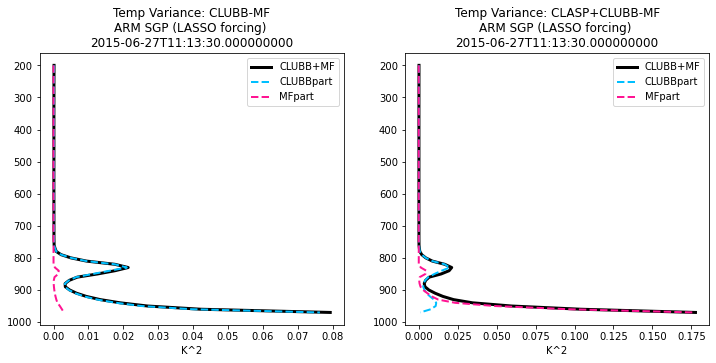

In [25]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_thlp2'
clubbVar = 'THLP2_CLUBB_interp'
mfVar    = 'edmf_S_ATHLTHL_interp'
unitsStr = 'K^2'
varName  = 'Temp Variance'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(np.squeeze(scamDS_h2[totVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF')), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(np.squeeze(scamDS_h2.total_thlp2.isel(time=selTime).sel(case='clasp+MF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF')), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)



Text(0.5, 0, 'm^2 s^-2')

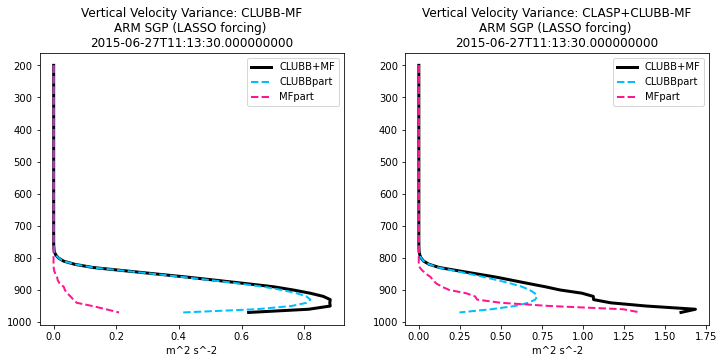

In [23]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_S_AWW_interp'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(np.squeeze(scamDS_h2[totVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF')), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(np.squeeze(scamDS_h2[totVar].isel(time=selTime).sel(case='clasp+MF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clasp+MF')), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)


## Plots and Analysis 

### PDFs

In [26]:
scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='clasp+MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]


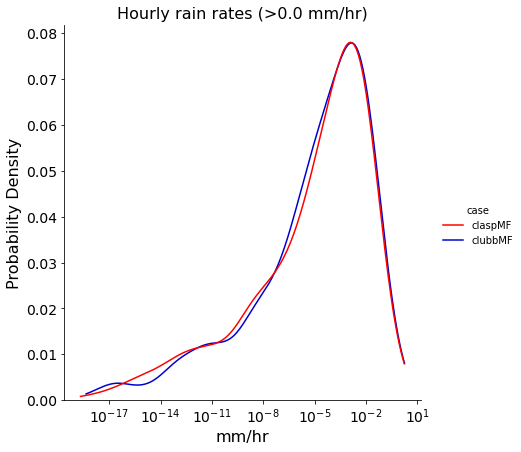

In [27]:
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['red','mediumblue'], legend=True)

# g.ax.set_xlim([10**-13, 10**1])
g.ax.set_title("Hourly rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
# plt.setp(g._legend.get_title(), fontsize=14)
# plt.setp(g._legend.get_texts(), fontsize=14)
# plt.setp(g.ax.lines[5], linestyle='--')   # Index goes in reverse order 
# plt.legend(loc='upper left', 
#            labels=['Obs','LES_HMG','LES_HTG','SCAM_HMG','SCAM_HTG',r"SCAM_HTG$_\alpha$",r"SCAM_HTG$_{100}$"], 
#            ncol=2, fontsize=12)




[None, None, None, None]

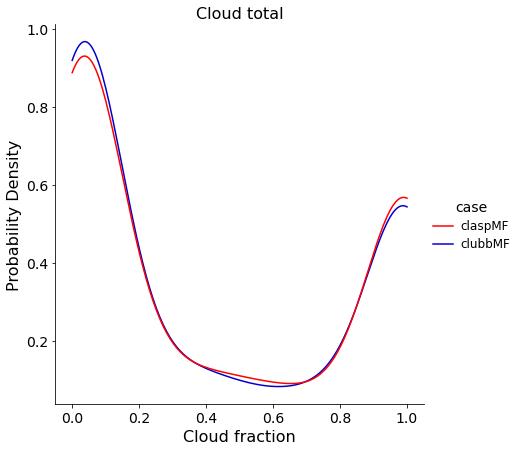

In [66]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# Limit to daytime hours
selHours = np.where(scamCLD['time.hour'].values<=19)[0]
scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF').values
cldHTG_scam = scamCLD.sel(case='clasp+MF').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Cloud Fraction', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("Cloud total", fontsize=16 ) 
g.ax.set_xlabel('Cloud fraction',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


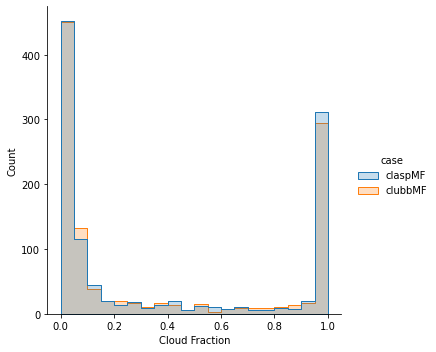

In [34]:
sns.displot(dfReal, x='Cloud Fraction',hue='case',element='step',binwidth=0.05)

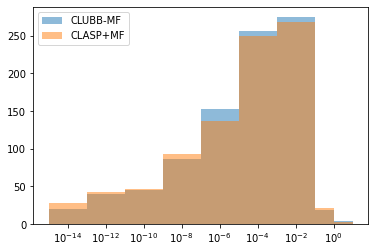

In [25]:
binEdges = [10e-16, 10e-14, 10e-12, 10e-10, 10e-8, 10e-6, 10e-4, 10e-2, 10e-1,10]

plt.hist(np.squeeze(rainRatesHMG_scam),alpha = 0.5, bins=binEdges)
plt.hist(np.squeeze(rainRatesHTG_scam), alpha=0.5, bins=binEdges)

plt.xscale('log')
plt.legend(['CLUBB-MF', 'CLASP+MF'])


In [26]:
upthl_clubbMF = scamDS_h2.thlu_macmicAvg_interp.sel(case='clubbMF')
upthl_claspMF = scamDS_h2.thlu_macmicAvg_interp.sel(case='clasp+MF')

countValPlumes_clubb = np.zeros([len(upthl_clubbMF.levInterp.values)])
countValPlumes_clasp = np.zeros([len(upthl_clubbMF.levInterp.values)])

for iLev in range(len(upthl_clubbMF.levInterp.values)):
    countValPlumes_clubb[iLev] = np.shape(np.where( np.isfinite(upthl_clubbMF.isel(levInterp=iLev))==True))[1]
    countValPlumes_clasp[iLev] = np.shape(np.where( np.isfinite(upthl_claspMF.isel(levInterp=iLev))==True))[1]


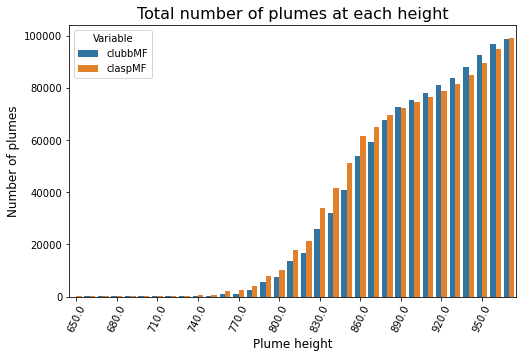

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))    

levs = upthl_claspMF.levInterp.values
dfLevInfo = pd.DataFrame({'Level': levs[45::],
                          'clubbMF': countValPlumes_clubb[45::], 
                          'claspMF': countValPlumes_clasp[45::]})
tidy = dfLevInfo.melt(id_vars='Level').rename(columns=str.title)

g = sns.barplot(x='Level',y='Value',hue='Variable',data=tidy)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::3])
plt.xticks(rotation=65)
ax.set_ylabel('Number of plumes',fontsize=12)
ax.set_xlabel('Plume height',fontsize=12)
ax.set_title('Total number of plumes at each height', fontsize=16)

plt.show()

### Diurnal cycle plots

In [94]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')

hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')

# ## Get mean hourly LES values too 
# hrLES_newDefault = LES_newDefault.groupby('Time.hour').mean(dim='Time')
# hrLES_moments    = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')



In [61]:
# pltVar = 'RTPTHLP_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# # ctrlCase2 = 'clubbMF_setSfcFlux'
# # testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values)*1e-3, 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values)*1e-3, 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values)*1e-3, 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values)*1e-3, 
# #          color='dodgerblue', linestyle='--', label=testCase2)

# axs.legend(fontsize=12)

# axs.set_ylabel('K kg/kg')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)


In [62]:
# pltVar = 'THLP2_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values), 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values), 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values), 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values), 
# #          color='dodgerblue', linestyle='--', label=testCase2)

# axs.legend(fontsize=12)

# axs.set_ylabel('K**2')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)



In [63]:
# pltVar = 'RTP2_CLUBB'

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

# fig,axs = plt.subplots(1,1, figsize=(7,4))

# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase).isel(ilev=-1).values)*((1e-3)**2), 
#          color='orangered', label=ctrlCase)
# axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase).isel(ilev=-1).values)*((1e-3)**2), 
#          color='dodgerblue', label=testCase)

# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=ctrlCase2).isel(ilev=-1).values)*((1e-3)**2), 
# #          color='orangered', linestyle='--', label=ctrlCase2)
# # axs.plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVar].sel(case=testCase2).isel(ilev=-1).values)*((1e-3)**2), 
# #          color='dodgerblue', linestyle='--', label=testCase2)


# axs.legend(fontsize=12)

# axs.set_ylabel('kg**2/kg**2')
# axs.set_xlabel('Hour')
# axs.set_title(pltVar +' (ilev=-1 [~30m])', fontsize=14)




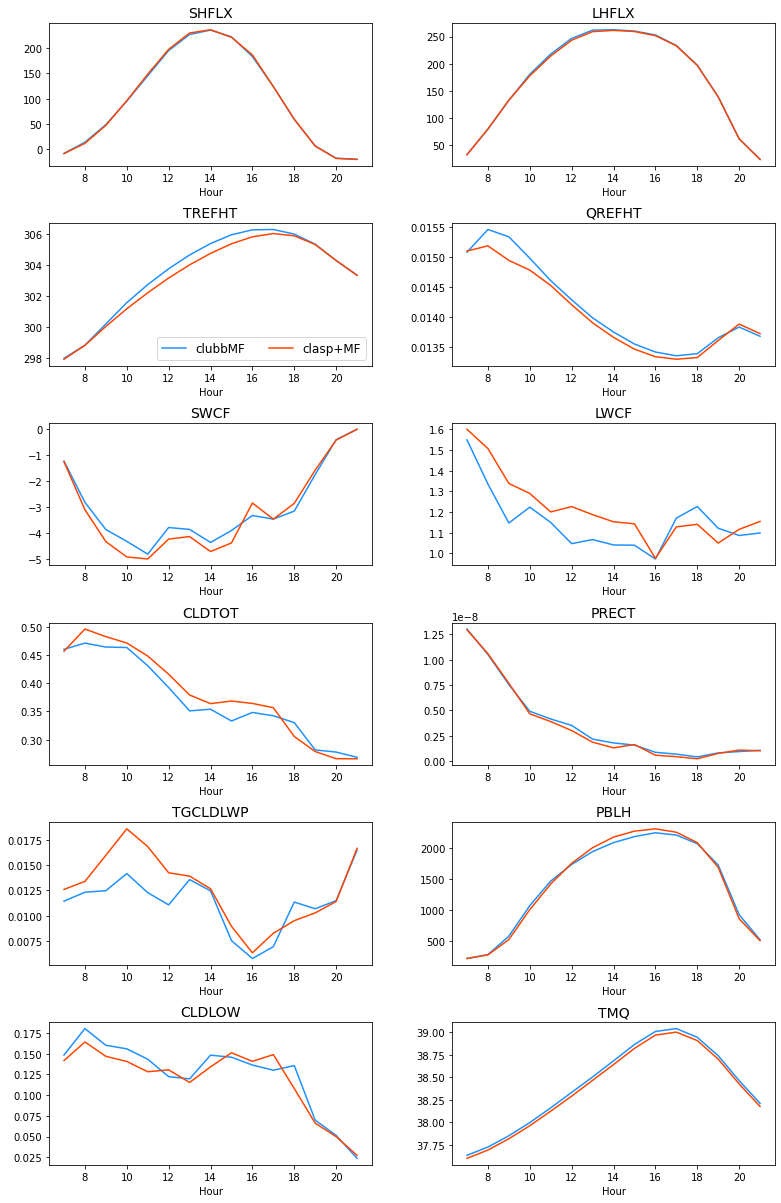

In [49]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

ctrlCase2 = 'clubbMF_setSfcFlux'
testCase2 = 'claspMF_setSfcFlux'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
    
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    if iPlt==2:
        axs[iPlt].legend(fontsize=12, ncol=2)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


In [26]:
uniqDays_scamHMG = scamDS.sel(case='clubbMF').resample(time='1D').mean().dropna(dim='time').time.values
print('SCAM days:    ',    len(uniqDays_scamHMG))
dates            = pd.DatetimeIndex(uniqDays_scamHMG)


SCAM days:     74


In [ ]:
# pltVars = [
#            'PRECT',
#            'TGCLDLWP',
#            ]

# ctrlCase  = 'clubbMF'
# testCase  = 'clasp+MF'

# fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(11,3.25*len(pltVars)/2) )
# axs      = axs.ravel()
# fig.subplots_adjust(wspace=0.25, hspace=0.4)

# for iPlt in range(len(pltVars)):

# #     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
# #              color='orangered',linewidth=3, label=ctrlCase)
# #     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
# #              color='dodgerblue',linewidth=3, label=testCase)
# #     axs[iPlt].legend(fontsize=12)
    
#     for iDay in range(len(dates)):
#         iselDate = np.where( (scamDS['time.year'].values==dates.year[iDay]) & 
#                              (scamDS['time.month'].values==dates.month[iDay]) & 
#                              (scamDS['time.day'].values==dates.day[iDay]) )[0]
#         scamSel = scamDS.isel(time=iselDate).groupby('time.hour').mean(dim='time')
        
# #         axs[iPlt].plot(scamSel['hour'].values, np.squeeze(scamSel[pltVars[iPlt]].sel(case=ctrlCase).values), 
# #              color='orangered',linewidth=0.5,alpha=0.4, label=ctrlCase)
#         axs[iPlt].plot(scamSel['hour'].values, 
#                        np.squeeze(scamSel[pltVars[iPlt]].sel(case=testCase).values - scamSel[pltVars[iPlt]].sel(case=ctrlCase).values), 
#              color='k',linewidth=0.5,alpha=0.4, label=testCase)

#     # axs.set_ylabel('K kg/kg')
#     axs[iPlt].set_xlabel('Hour')
#     axs[iPlt].set_title(pltVars[iPlt]+' [clasp - clubb]', fontsize=14)


### Mean profiles at certain hours?

(-0.5, 5.0)

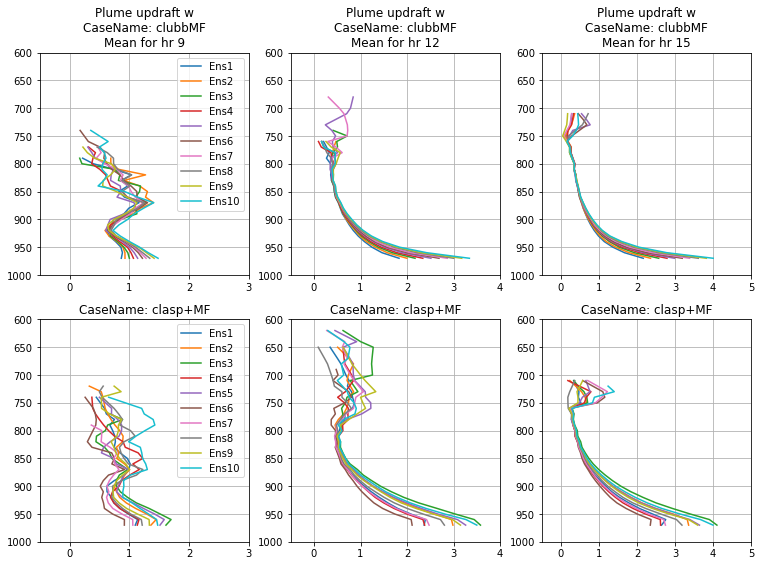

In [46]:
hoursList = [9,12,15]
fig,axs = plt.subplots(2,len(hoursList), figsize=(4.25*len(hoursList),9))
axs = axs.ravel()

caseSel1 = 'clubbMF'
caseSel2 = 'clasp+MF'
# caseSel1 = 'clubbMF_setSfcFlux'
# caseSel2 = 'claspMF_setSfcFlux'

# varSel   = 'edmf_upqt_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft qt'

# varSel   = 'edmf_upthl_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft thl'

varSel   = 'up_macmicAvg_interp' 
levVar   = 'levInterp'
longName = 'Plume updraft w'

# varSel   = 'edmf_upbuoy_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft buoyancy'

# varSel   = 'edmf_updet_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft detrainment'

# varSel   = 'edmf_upa_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft area'

for iHour in range(len(hoursList)):
    hourSel = hoursList[iHour]

    for iEns in range(len(hourlyMeanSCAM_h2.nens.values)):
        ensSel1 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel1).isel(lon=0,lat=0,nens=iEns)
        ensSel2 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel2).isel(lon=0,lat=0,nens=iEns)

        axs[iHour].plot(ensSel1[varSel].values, ensSel1[levVar].values, label='Ens'+str(iEns+1))
        axs[iHour+3].plot(ensSel2[varSel].values, ensSel2[levVar].values, label='Ens'+str(iEns+1))

    if iHour==0:
        axs[iHour].legend()
        axs[iHour+3].legend()
    
    axs[iHour].invert_yaxis()
    axs[iHour+3].invert_yaxis()

    axs[iHour].set_ylim([1000,600])
    axs[iHour+3].set_ylim([1000,600])

    axs[iHour].set_title(longName+'\nCaseName: '+caseSel1+'\nMean for hr '+str(hourSel))
    axs[iHour+3].set_title('CaseName: '+caseSel2)

    axs[iHour].grid()
    axs[iHour+3].grid()

# # EDMF_upthl limits: 
# axs[0].set_xlim([294,306])
# axs[3].set_xlim([294,306])

# axs[1].set_xlim([303,315])
# axs[4].set_xlim([303,315])

# axs[2].set_xlim([305,315])
# axs[5].set_xlim([305,315])

# # EDMF_upqt limits: 
# axs[0].set_xlim([0.01,0.0145])
# axs[3].set_xlim([0.01,0.0145])

# axs[1].set_xlim([0.008, 0.012])
# axs[4].set_xlim([0.008, 0.012])

# axs[2].set_xlim([0.008, 0.0115])
# axs[5].set_xlim([0.008, 0.0115])

# EDMF_upw limits: 
axs[0].set_xlim([-0.5,3])
axs[3].set_xlim([-0.5,3])

axs[1].set_xlim([-0.5, 4])
axs[4].set_xlim([-0.5, 4])

axs[2].set_xlim([-0.5, 5])
axs[5].set_xlim([-0.5, 5])



(300.0, 315.0)

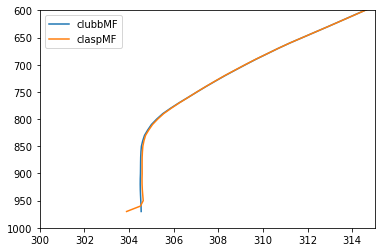

In [78]:
fig,axs = plt.subplots(1,1, figsize=(6,4))

hrSel = 15

axs.plot(np.squeeze(hourlyMeanSCAM.sel(case='clubbMF',hour=hrSel).THETAL_interp.values), 
         hourlyMeanSCAM.levInterp.values, label='clubbMF')
axs.plot(np.squeeze(hourlyMeanSCAM.sel(case='clasp+MF',hour=hrSel).THETAL_interp.values), 
         hourlyMeanSCAM.levInterp.values, label='claspMF')
axs.legend()
axs.invert_yaxis()
axs.set_ylim([1000,600])
axs.set_xlim([300,315])


Text(0.5, 0, 'm^2 s^-2')

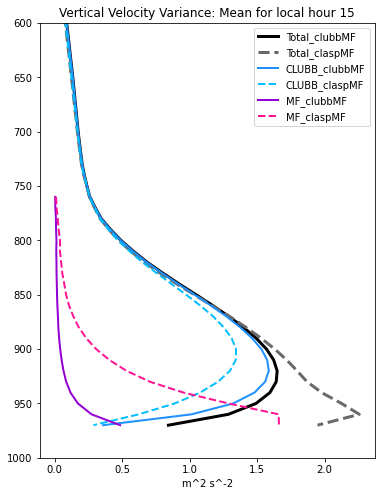

In [81]:
fig,axs = plt.subplots(1,1, figsize=(6,8))

# totVar   = 'total_thlp2'
# clubbVar = 'THLP2_CLUBB_interp'
# mfVar    = 'edmf_thlp2'
# unitsStr = 'K^2'
# varName  = 'Temp Variance'


totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_wp2'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'


maxLev   = 600 
selHr    = 15

colorsel = ['black','deepskyblue','deeppink']

axs.plot(hourlyMeanSCAM_h2[totVar].sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='black',linestyle='-', linewidth=3, 
            label='Total_clubbMF')
axs.plot(hourlyMeanSCAM_h2[totVar].sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='dimgrey',linestyle='--', linewidth=3, 
            label='Total_claspMF')

axs.plot(hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM.levInterp.values, 
            color='dodgerblue',linestyle='-', linewidth=2, 
            label='CLUBB_clubbMF')
axs.plot(hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM.levInterp.values, 
            color='deepskyblue',linestyle='--', linewidth=2, 
            label='CLUBB_claspMF')

axs.plot(hourlyMeanSCAM_h2[mfVar].sel(case='clubbMF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='darkviolet',linestyle='-', linewidth=2, 
            label='MF_clubbMF')
axs.plot(hourlyMeanSCAM_h2[mfVar].sel(case='clasp+MF',hour=selHr), 
            hourlyMeanSCAM_h2.levInterp.values, 
            color='deeppink',linestyle='--', linewidth=2, 
            label='MF_claspMF')

# axs[0].plot(scamDS[clubbVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
#             scamDS.levInterp.values, 
#             color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
#             label='CLUBBpart')

# axs[0].plot(scamDS_h2[mfVar].isel(time=selTime,lon=0,lat=0).sel(case='clubbMF'), 
#             scamDS_h2.levInterp.values, 
#             color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
#             label='MFpart')


axs.legend()
axs.invert_yaxis()
axs.set_ylim([1000,maxLev])
axs.set_title(varName+': Mean for local hour '+str(selHr))
axs.set_xlabel(unitsStr)

# axs.axvline(0,color='orange',alpha=0.9,linestyle=':')

In [83]:
sumVar = hourlyMeanSCAM[clubbVar].isel(lon=0,lat=0).sel(case='clubbMF',hour=selHr) + hourlyMeanSCAM_h2[mfVar].sel(case='clubbMF',hour=selHr) 



In [84]:
for ilev in range(len(hourlyMeanSCAM.levInterp.values)):
    if sumVar[ilev]==hourlyMeanSCAM_h2[totVar].isel(levInterp=ilev).sel(case='clubbMF',hour=selHr):
        print('cool, match at level ', hourlyMeanSCAM.levInterp.values[ilev])
    else:
        print('ERROR at level ', hourlyMeanSCAM.levInterp.values[ilev])
        print('   sumVar = ',sumVar[ilev].values)
        print('   levVar = ',hourlyMeanSCAM_h2[totVar].isel(levInterp=ilev).sel(case='clubbMF',hour=selHr).values)
    

ERROR at level  200.0
   sumVar =  nan
   levVar =  0.00047549840388336
ERROR at level  210.0
   sumVar =  nan
   levVar =  0.0007945166030795027
ERROR at level  220.0
   sumVar =  nan
   levVar =  0.0025257933319838906
ERROR at level  230.0
   sumVar =  nan
   levVar =  0.004849850946898459
ERROR at level  240.0
   sumVar =  nan
   levVar =  0.006142215692338495
ERROR at level  250.0
   sumVar =  nan
   levVar =  0.008105069775268701
ERROR at level  260.0
   sumVar =  nan
   levVar =  0.011150786346805545
ERROR at level  270.0
   sumVar =  nan
   levVar =  0.013017800301513574
ERROR at level  280.0
   sumVar =  nan
   levVar =  0.01414544381843339
ERROR at level  290.0
   sumVar =  nan
   levVar =  0.015391724282369564
ERROR at level  300.0
   sumVar =  nan
   levVar =  0.016919504477302703
ERROR at level  310.0
   sumVar =  nan
   levVar =  0.016971378353168892
ERROR at level  320.0
   sumVar =  nan
   levVar =  0.016490302313795415
ERROR at level  330.0
   sumVar =  nan
   levVar = 

### Look at mean over certain periods

In [96]:
iMorn = np.where((scamDS['time.hour'].values>=8) & (scamDS['time.hour'].values<=10))[0]
iAftn = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=17))[0]
iEvng = np.where((scamDS['time.hour'].values>=18) & (scamDS['time.hour'].values<=20))[0]

mornDS = scamDS.isel(time=iMorn, lat=0, lon=0).mean(dim='time')
aftnDS = scamDS.isel(time=iAftn, lat=0, lon=0).mean(dim='time')
evngDS = scamDS.isel(time=iEvng, lat=0, lon=0).mean(dim='time')

mornDS_h2 = scamDS_h2.isel(time=iMorn, lat=0, lon=0).mean(dim='time')
aftnDS_h2 = scamDS_h2.isel(time=iAftn, lat=0, lon=0).mean(dim='time')
evngDS_h2 = scamDS_h2.isel(time=iEvng, lat=0, lon=0).mean(dim='time')


In [69]:
tableVars = ['PRECT','CLDTOT','TGCLDLWP','TMQ','CLDLOW','SWCF','LWCF']

print('                                       clubb/clasp')
print('                    (8-10a)             (12-5p)                (6-8p)')
print('Variable          MorningMean        AfternoonMean        EveningMean')
  
for iVar in range(len(tableVars)):
    print('%10s  %8.3f / %7.3f  %8.3f / %7.3f  %8.3f / %7.3f' % (tableVars[iVar], 
                    mornDS[tableVars[iVar]].sel(case='clubbMF'), mornDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    aftnDS[tableVars[iVar]].sel(case='clubbMF'), aftnDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    evngDS[tableVars[iVar]].sel(case='clubbMF'), evngDS[tableVars[iVar]].sel(case='clasp+MF'), 
                                  ) )
    
    

                                       clubb/clasp
                    (8-10a)             (12-5p)                (6-8p)
Variable          MorningMean        AfternoonMean        EveningMean
     PRECT     0.000 /   0.000     0.000 /   0.000     0.000 /   0.000
    CLDTOT     0.466 /   0.484     0.354 /   0.375     0.297 /   0.284
  TGCLDLWP     0.013 /   0.016     0.010 /   0.011     0.011 /   0.010
       TMQ    37.855 /  37.822    38.738 /  38.698    38.715 /  38.678
    CLDLOW     0.166 /   0.151     0.134 /   0.137     0.086 /   0.075
      SWCF    -3.652 /  -4.101    -3.768 /  -3.946    -1.760 /  -1.610
      LWCF     1.236 /   1.379     1.056 /   1.136     1.145 /   1.102


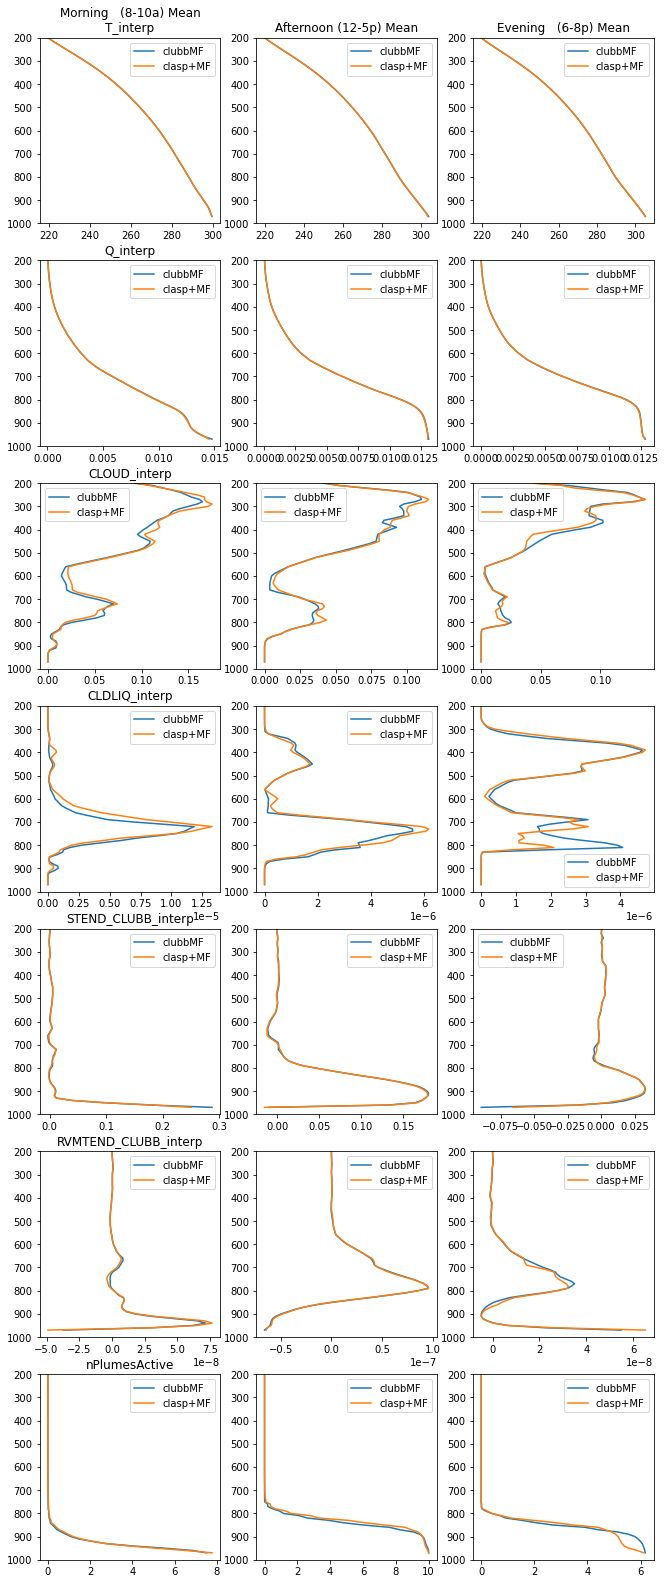

In [109]:
pltVars = ['T_interp','Q_interp','CLOUD_interp','CLDLIQ_interp',
           'STEND_CLUBB_interp','RVMTEND_CLUBB_interp',
           'nPlumesActive']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 200

minX = [280, 0.005, -0.01, -0.1e-5]
maxX = [308, 0.013, 0.06,  1.2e-5]

useH2 = False

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values, 
                           mornDS_h2.levInterp.values)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
#     axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
#     axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
#     axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning   (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-5p) Mean')
        axs[iVar+2].set_title('Evening   (6-8p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])

    

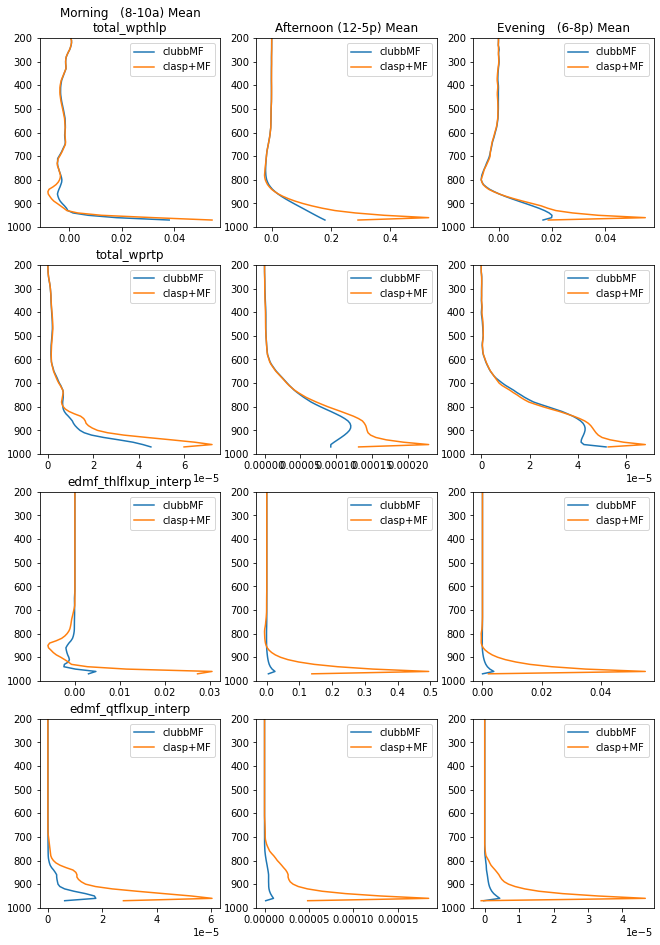

In [111]:
pltVars = ['total_wpthlp','total_wprtp',
           'edmf_thlflxup_interp', 'edmf_qtflxup_interp']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 200

minX = [280, 0.005, -0.01, -0.1e-5]
maxX = [308, 0.013, 0.06,  1.2e-5]

useH2 = True

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(np.squeeze(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS_h2.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS_h2.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS_h2.levInterp.values, label=testCase)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
#     axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
#     axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
#     axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning   (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-5p) Mean')
        axs[iVar+2].set_title('Evening   (6-8p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])
    

### Time-height plots

In [50]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)


In [51]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2




**SCAM HOM case and HET-HOM case**

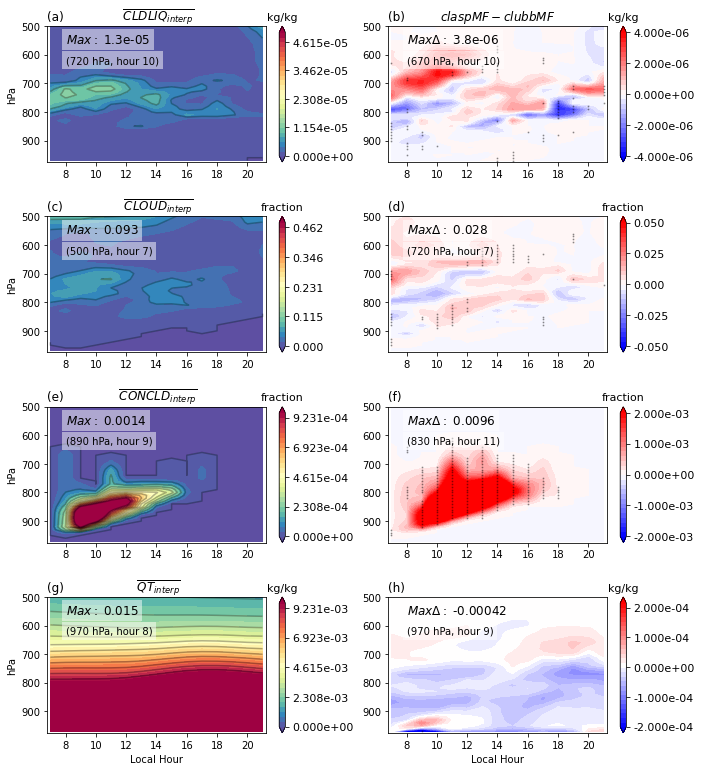

In [40]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.1e-2,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 500

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater




subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

# ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
# testDS    = hourlyMeanSCAM.sel(case=testCase)
# diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        




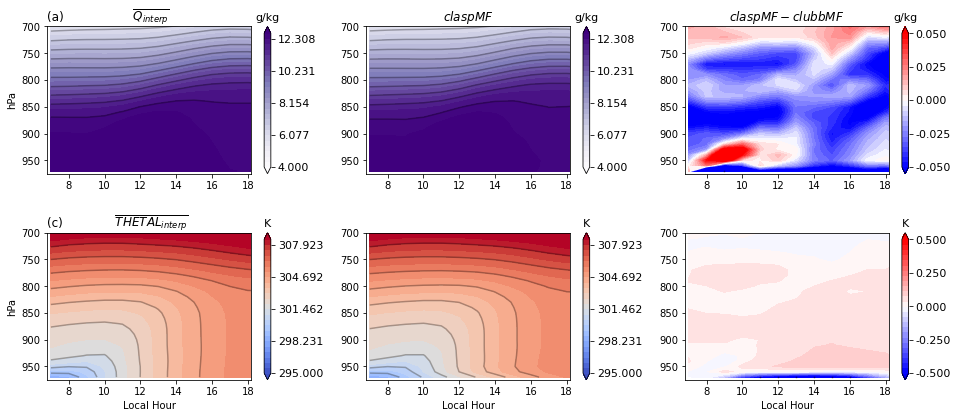

In [41]:
# Set up figure
pltVars  = ['Q_interp',
            'THETAL_interp',
           ]

cMin    = [4, 
           295.0,
          ]

cMax    = [13,
           309,
          ]

diffMax = [0.05,
           0.5,
          ]

multpl = [
          1e3,
          1,
         ]

maxLev  = 700

units = [
         r'g/kg',
         r'K',
        ]

cfmt_hmg = ['%.3f', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3f', '%.3f'] # colorbar label formater

cmapSel = ['Purples', 'coolwarm']


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{Q_{interp}}$",
               r" $\overline{THETAL_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 3, figsize=(16,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*3].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap=cmapSel[iVar], extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*3)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*3)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*3].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
#     ## Add inset text for max/min
#     varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

#     axs[iVar*3].text(8,760,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[iVar*3].text(8,830,'(%i hPa, hour %i)' % (varHgt,varTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))


    # - - - - Plot test case - - - -
    cplt = axs[(iVar*3)+1].contourf(testDS.hour.values, testDS.levInterp.values, 
                       np.squeeze(testDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap=cmapSel[iVar], extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+1], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+1], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[(iVar*3)+1].contour(testDS.hour.values, testDS.levInterp.values, 
                    np.squeeze(testDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
#     ## Add inset text for max/min
#     varVal,varHgt,varTime = getMaxValHeightTime(testDS, pltVars[iVar], maxLev, 'levInterp','hour')

#     axs[(iVar*3)+1].text(8,760,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[(iVar*3)+1].text(8,830,'(%i hPa, hour %i)' % (varHgt,varTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))


    
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*3)+2].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*3)+2], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
#     ## Add inset text for max difference 
#     diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
#     axs[(iVar*3)+2].text(8,760,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
#                 fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
#     axs[(iVar*3)+2].text(8,830,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
#                 fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*3)+2].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*3].invert_yaxis()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+2].invert_yaxis()

    axs[(iVar*3)].set_ylim([975, maxLev])
    axs[(iVar*3)+1].set_ylim([975, maxLev])
    axs[(iVar*3)+2].set_ylim([975, maxLev])

    axs[(iVar*3)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*3)].set_title(varLabel[iVar])
    
    if iVar==0:
#         axs[(iVar*3)+2].set_title(subPltLabel[iVar][1], loc='left')
#         axs[(iVar*3)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*3)+2].set_title(r'$claspMF - clubbMF$')
        axs[(iVar*3)+1].set_title(r'$claspMF$')
#     else: 
#         axs[(iVar*3)+1].set_title(subPltLabel[iVar][1], loc='left')
#         axs[(iVar*3)+2].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*3)].set_ylabel('hPa')
    
    axs[(iVar*3)].set_xlim([6.8,18.2])
    axs[(iVar*3)+1].set_xlim([6.8,18.2])
    axs[(iVar*3)+2].set_xlim([6.8,18.2])
    axs[(iVar*3)].set_xticks([8,10,12,14,16,18])
    axs[(iVar*3)+1].set_xticks([8,10,12,14,16,18])
    axs[(iVar*3)+2].set_xticks([8,10,12,14,16,18])

    
    if iVar==len(pltVars)-1: 
        axs[(iVar*3)].set_xlabel('Local Hour')
        axs[(iVar*3)+1].set_xlabel('Local Hour')
        axs[(iVar*3)+2].set_xlabel('Local Hour')

plt.show()


In [42]:
# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2

In [43]:
CI_h2           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2']
ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'], -CI_h2])

ctrlDS_lowCI

176.15019616244868

In [70]:
np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'], -CI_h2], axis=0)[1,-1]

0.1040094535342929

In [71]:
CI_h2.values[1,-1]

0.008573950331313085

In [72]:
hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)['total_wp2'].values[1,-1] 

0.11258340386560599

In [52]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase, CIlevel): 

    ## Get ranges for each case's CI 
    CI_h2_ctrl           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel]
    CI_h2_test           = CIlevel*hourlySE_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel]

#     ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], -CI_h2_ctrl], axis=0)
#     testDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], -CI_h2_test], axis=0)

#     ctrlDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], CI_h2_ctrl], axis=0)
#     testDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], CI_h2_test], axis=0)

    ctrlDS_lowCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel] -CI_h2_ctrl
    testDS_lowCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel] -CI_h2_test

    ctrlDS_hghCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel] + CI_h2_ctrl
    testDS_hghCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel] + CI_h2_test



    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

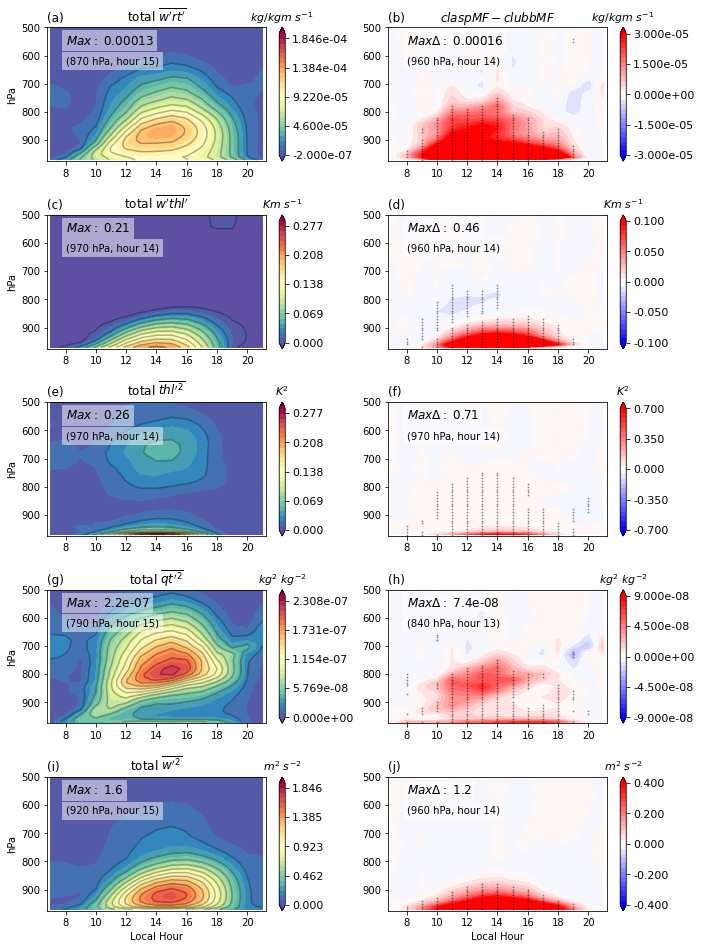

In [55]:
# Set up figure
pltVars  = [
            'total_wprtp',
            'total_wpthlp', 
            'total_thlp2',
            'total_rtp2',
            'total_wp2',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"total $\overline{w'rt'}$",
               r"total $\overline{w'thl'}$",
               r"total $\overline{thl'^2}$",
               r"total $\overline{qt'^2}$",
               r"total $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


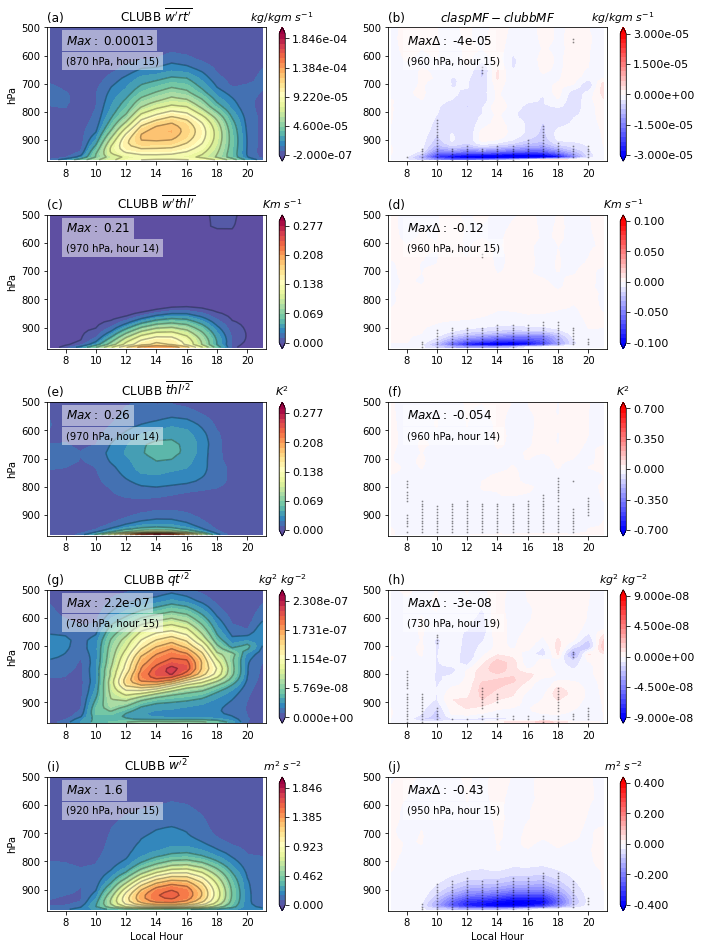

In [61]:
# Set up figure -- CLUBB components 
pltVars  = [
            'wprtp_interp',
            'wpthlp_interp', 
            'THLP2_CLUBB_interp',
            'RTP2_CLUBB_interp',
            'WP2_CLUBB_interp',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1e-6, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"CLUBB $\overline{w'rt'}$",
               r"CLUBB $\overline{w'thl'}$",
               r"CLUBB $\overline{thl'^2}$",
               r"CLUBB $\overline{qt'^2}$",
               r"CLUBB $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


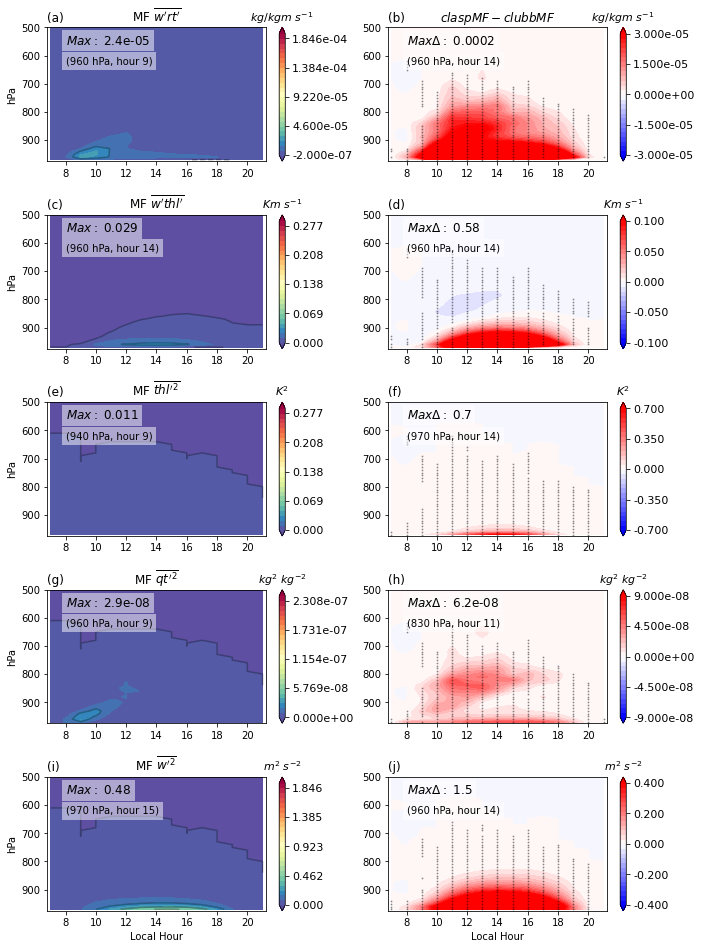

In [63]:
# Set up figure -- EDMF components 
pltVars  = [
            'edmf_qtflxup_interp',
            'edmf_thlflxup_interp', 
            'edmf_S_ATHLTHL_interp',
            'edmf_S_AQTQT_interp',
            'edmf_S_AWW_interp',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"MF $\overline{w'rt'}$",
               r"MF $\overline{w'thl'}$",
               r"MF $\overline{thl'^2}$",
               r"MF $\overline{qt'^2}$",
               r"MF $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


### Grab a few days at random and look at individual days

In [161]:
yrSelList  = [2017,2016,2017]
monSelList = [9,   6,   7]
daySelList = [24,  10,  16]

iselDate1 = np.where( (scamDS['time.year'].values==yrSelList[0]) & 
                      (scamDS['time.month'].values==monSelList[0]) & 
                      (scamDS['time.day'].values==daySelList[0]) )[0]
scamSel1 = scamDS.isel(time=iselDate1).groupby('time.hour').mean(dim='time')


iselDate2 = np.where( (scamDS['time.year'].values==yrSelList[1]) & 
                      (scamDS['time.month'].values==monSelList[1]) & 
                      (scamDS['time.day'].values==daySelList[1]) )[0]
scamSel2 = scamDS.isel(time=iselDate2).groupby('time.hour').mean(dim='time')


iselDate3 = np.where( (scamDS['time.year'].values==yrSelList[2]) & 
                      (scamDS['time.month'].values==monSelList[2]) & 
                      (scamDS['time.day'].values==daySelList[2]) )[0]
scamSel3 = scamDS.isel(time=iselDate3).groupby('time.hour').mean(dim='time')



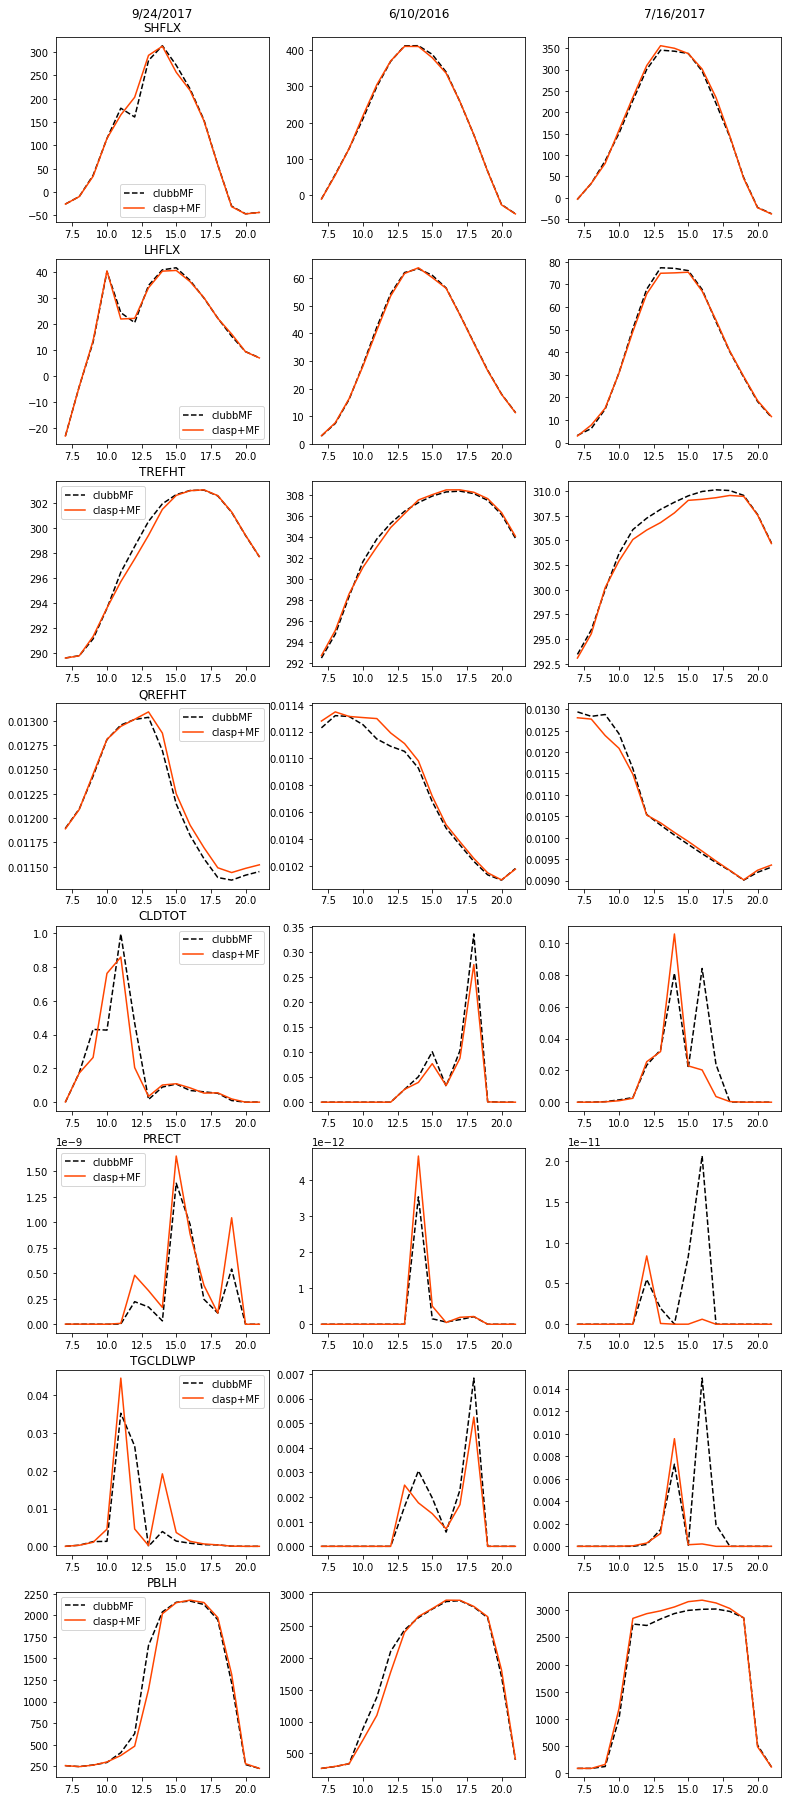

In [163]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
#            'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',]

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

fig,axs = plt.subplots(len(pltVars),3, figsize=(13,4*len(pltVars)))
axs     = axs.ravel()

for iPlt in range(len(pltVars)):

    ## Day 1
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    ## Day 2
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    ## Day 3
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    if iPlt==0: 
        axs[iPlt*3].set_title(str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0])+'\n'+pltVars[iPlt])
        axs[iPlt*3+1].set_title(str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1])+'\n')
        axs[iPlt*3+2].set_title(str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2])+'\n')
    else: 
        axs[iPlt*3].set_title(pltVars[iPlt])
        
    axs[iPlt*3].legend()
    
    

Text(0.5, 0, 'Local Hour')

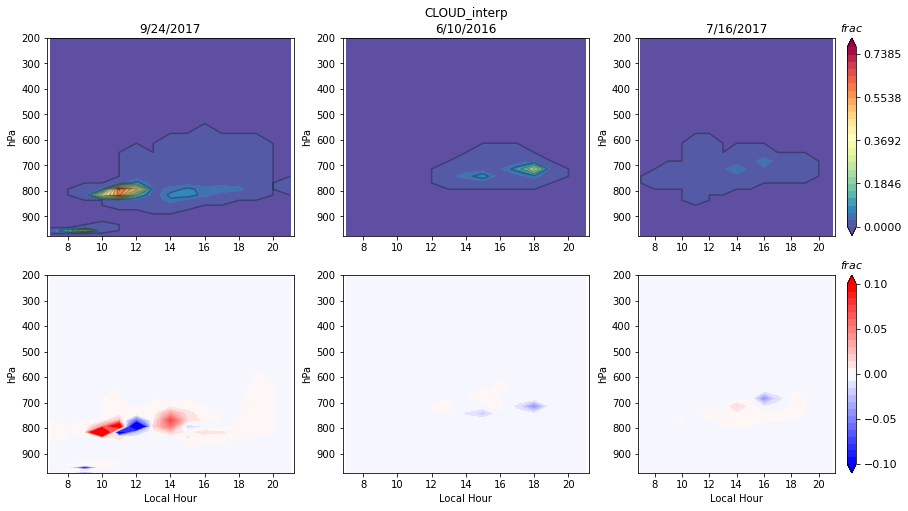

In [41]:
# pltVar  = 'THLP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 0.1
# diffMax = 0.01
# multpl  = 1 
# maxLev  = 500 
# unitsStr = r'$K^2$'

# pltVar  = 'RTP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 2.0e-7
# diffMax = 0.4e-7
# multpl  = 1e-6 
# maxLev  = 500 
# unitsStr = r'$kg^2/kg^2$'

pltVar  = 'CLOUD_interp'
cMin    = 0.0 
cMax    = 0.8
diffMax = 0.1
multpl  = 1 
maxLev  = 200 
unitsStr = r'$frac$'

fig,axs = plt.subplots(2,3, figsize=(15,8))
axs     = axs.ravel()

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'


## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 1 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel1.sel(case=ctrlCase)
testDS    = scamSel1.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[0].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[0].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )

# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[3].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 2
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel2.sel(case=ctrlCase)
testDS    = scamSel2.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[1].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[1].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[4].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 3 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel3.sel(case=ctrlCase)
testDS    = scamSel3.sel(case=testCase)
diffCases = testDS - ctrlDS

# - - - - Plot control case - - - -
cplt = axs[2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')
# Add colorbar
if (pltVar=='RTPTHLP_CLUBB_interp'):
        cbar = fig.colorbar(cplt, ax=axs[2],ticks=[cMin, cMin/2, 0, cMax/2, cMax])
else: 
    cbar = fig.colorbar(cplt, ax=axs[2])
    cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 


# Add contour lines
cplt = axs[2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[5].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

cbar = fig.colorbar(cplt, ax=axs[5],ticks=[-diffMax, -diffMax/2, 0, diffMax/2, diffMax])
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Other plot options 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

axs[0].set_title('\n'+str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0]))
axs[1].set_title(pltVar+'\n'+str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1]))
axs[2].set_title('\n'+str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2]))

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()


axs[0].set_ylim([975, maxLev])
axs[1].set_ylim([975, maxLev])
axs[2].set_ylim([975, maxLev])
axs[3].set_ylim([975, maxLev])
axs[4].set_ylim([975, maxLev])
axs[5].set_ylim([975, maxLev])

axs[0].set_ylabel('hPa')
axs[1].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[3].set_ylabel('hPa')
axs[4].set_ylabel('hPa')
axs[5].set_ylabel('hPa')

axs[0].set_xlim([6.8,21.2])
axs[1].set_xlim([6.8,21.2])
axs[2].set_xlim([6.8,21.2])
axs[3].set_xlim([6.8,21.2])
axs[4].set_xlim([6.8,21.2])
axs[5].set_xlim([6.8,21.2])

axs[0].set_xticks([8,10,12,14,16,18,20])
axs[1].set_xticks([8,10,12,14,16,18,20])
axs[2].set_xticks([8,10,12,14,16,18,20])
axs[3].set_xticks([8,10,12,14,16,18,20])
axs[4].set_xticks([8,10,12,14,16,18,20])
axs[5].set_xticks([8,10,12,14,16,18,20])

axs[3].set_xlabel('Local Hour')
axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')


## Assess what's happening in the land

## Scratch work

In [69]:
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxTRUE_fixEvap.LASSO_20180605.budgetMFvars001'
caseDir = '/project/amp/mdfowler/cases/'
histDir = '/run/atm/hist/'

listFiles_h2 = np.sort(glob.glob(caseDir+caseName+histDir+'*cam.h2*'))

testDS = xr.open_dataset(listFiles_h2[0], decode_times=True)


(1000.0, 500.0)

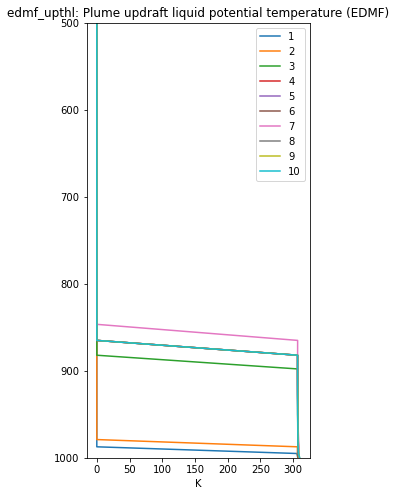

In [84]:
nens = 10
fig,axs = plt.subplots(1,1, figsize=(4,8))

pltVar = 'edmf_upthl'

for iEns in range(nens):
    axs.plot(testDS[pltVar].values[200,iEns,:,0,0], testDS.ilev.values,label=str(iEns+1))
    
axs.invert_yaxis()
axs.legend()
axs.set_title(pltVar+': '+testDS[pltVar].long_name)
axs.set_xlabel(testDS[pltVar].units)
axs.set_ylim([1000,500])


In [70]:
testDS

<xarray.Dataset>
Dimensions:         (ilev: 59, lat: 1, lev: 58, lon: 1, nbnd: 2, nens: 10, time: 865)
Coordinates:
  * lat             (lat) float64 36.6
  * lon             (lon) float64 262.5
  * lev             (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev            (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * time            (time) object 2018-06-05 05:01:00 ... 2018-06-08 05:01:00
Dimensions without coordinates: nbnd, nens
Data variables:
    ntrk            int32 ...
    ntrn            int32 ...
    ntrm            int32 ...
    gw              (lat) float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    P0              float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    date            (time) int32 ...
    datesec         (time) int32 ...
    time_bnds       (time, nbnd) object ...
    date_written    (time) |S8 ...
    time_written    (time) |S8 ...
    ndbase          int32 ...
    nsbase          int32 ...
    nbdate          int32 ...
    nbsec           int32 ...
    mdt             int32 ...
    ndcur           (time) int32 ...
    nscur           (time) int32 ...
    co2vmr          (time) float64 ...
    ch4vmr          (time) float64 ...
    n2ovmr          (time) float64 ...
    f11vmr          (time) float64 ...
    f12vmr          (time) float64 ...
    sol_tsi         (time) float64 ...
    nsteph          (time) int32 ...
    edmf_DRY_A      (time, ilev, lat, lon) float32 ...
    edmf_DRY_QT     (time, ilev, lat, lon) float32 ...
    edmf_DRY_THL    (time, ilev, lat, lon) float32 ...
    edmf_DRY_W      (time, ilev, lat, lon) float32 ...
    edmf_MOIST_A    (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QC   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QT   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_THL  (time, ilev, lat, lon) float32 ...
    edmf_MOIST_W    (time, ilev, lat, lon) float32 ...
    edmf_cloudfrac  (time, lev, lat, lon) float32 ...
    edmf_dnqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_dnthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_dnw        (time, nens, ilev, lat, lon) float32 ...
    edmf_precc      (time, ilev, lat, lon) float32 ...
    edmf_qtflxdn    (time, ilev, lat, lon) float32 ...
    edmf_qtflxup    (time, ilev, lat, lon) float32 ...
    edmf_qtforcdn   (time, lev, lat, lon) float32 ...
    edmf_qtforcup   (time, lev, lat, lon) float32 ...
    edmf_rcm        (time, ilev, lat, lon) float32 ...
    edmf_thlflxdn   (time, ilev, lat, lon) float32 ...
    edmf_thlflxup   (time, ilev, lat, lon) float32 ...
    edmf_thlforcdn  (time, lev, lat, lon) float32 ...
    edmf_thlforcup  (time, lev, lat, lon) float32 ...
    edmf_upa        (time, nens, ilev, lat, lon) float32 ...
    edmf_upbuoy     (time, nens, ilev, lat, lon) float32 ...
    edmf_updet      (time, nens, ilev, lat, lon) float32 ...
    edmf_upent      (time, nens, ilev, lat, lon) float32 ...
    edmf_upmf       (time, nens, ilev, lat, lon) float32 ...
    edmf_upqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_upth       (time, nens, ilev, lat, lon) float32 ...
    edmf_upthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_upthv      (time, nens, ilev, lat, lon) float32 ...
    edmf_upw        (time, nens, ilev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_set...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_5